![image.png](https://miro.medium.com/max/1190/1*tAh0R8C8e9EHg3pBuBGoPQ.png)

# **Hugging Face Transformers**

> [**Hugging Face - Website**](https://huggingface.co/)

> [**Hugging Face - Github**](https://github.com/huggingface)

In [ ]:
!pip install transformers

In [ ]:
# Import Library.
import pandas as pd
import numpy as np
import tensorflow as tf
import warnings

warnings.filterwarnings("ignore")

# Load Dataset.
data = pd.read_csv("spam.csv")
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# Class Frequency.
print(data["Category"].value_counts())

ham     4825
spam     747
Name: Category, dtype: int64


In [ ]:
# Text Preprocessing.
data["class"] = data["Category"].apply(lambda x: 1 if x == "spam" else 0)

# Split Dataset into Training and Test Set.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data["Message"],
    data["class"],
    test_size=0.25,
    random_state=1,
    stratify=data["class"],
)

### **BERT Large Model (Uncased)** 

**Hugging Face:** [**bert-large-uncased**](https://huggingface.co/bert-large-uncased)

In [ ]:
# Download the "bert-large-uncased" Model from Hugging Face 🤗 Transformers.
from transformers import AutoTokenizer, TFBertModel

tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased")
bert = TFBertModel.from_pretrained("bert-large-uncased")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
tokenizer("I am Aritra Ganguly. I have a Master's in Data Science.")

{'input_ids': [101, 1045, 2572, 10488, 6494, 6080, 5313, 2100, 1012, 1045, 2031, 1037, 3040, 1005, 1055, 1999, 2951, 2671, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
print("Maximum length of Sentence is", max([len(x.split()) for x in X_train]))

Maximum length of Sentence is 171


In [ ]:
# Encode Train Dataset.
X_train_encode = tokenizer(
    text=X_train.tolist(),
    add_special_tokens=True,
    max_length=72,
    truncation=True,
    padding=True,
    return_tensors="tf",
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True,
)

In [ ]:
X_train_encode["input_ids"].shape

TensorShape([4179, 72])

In [ ]:
X_train_encode["attention_mask"].shape

TensorShape([4179, 72])

In [ ]:
# Import Library.
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [ ]:
# Model Configuration.
OPTIMIZER = Adam(
    learning_rate=6e-06,  # This learning rate is for the BERT Model taken from the Hugging Face 🤗 Website.
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0,
)
MAX_LEN = 72

# Model Architecture/Pipeline.
def create_model():
    # Pretrained BERT Model.
    input_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
    input_mask = Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")
    embeddings = bert(input_ids, attention_mask=input_mask)[1]
    # Fine-Tuning BERT Model.
    ml = tf.keras.layers.Dropout(0.1)(embeddings)
    ml = Dense(128, activation="relu")(ml)
    ml = tf.keras.layers.Dropout(0.1)(ml)
    ml = Dense(32, activation="relu")(ml)
    y = Dense(1, activation="sigmoid")(ml)
    # Final Model Construction.
    model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
    model.layers[2].trainable = True
    # Compile the Model.
    model.compile(
        optimizer=OPTIMIZER,
        loss=BinaryCrossentropy(from_logits=True),
        metrics=BinaryAccuracy("accuracy"),
    )
    return model


# Call the Model Architecture.
model = create_model()

# Build the Model.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 72)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 72)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  335141888   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 72,                                            

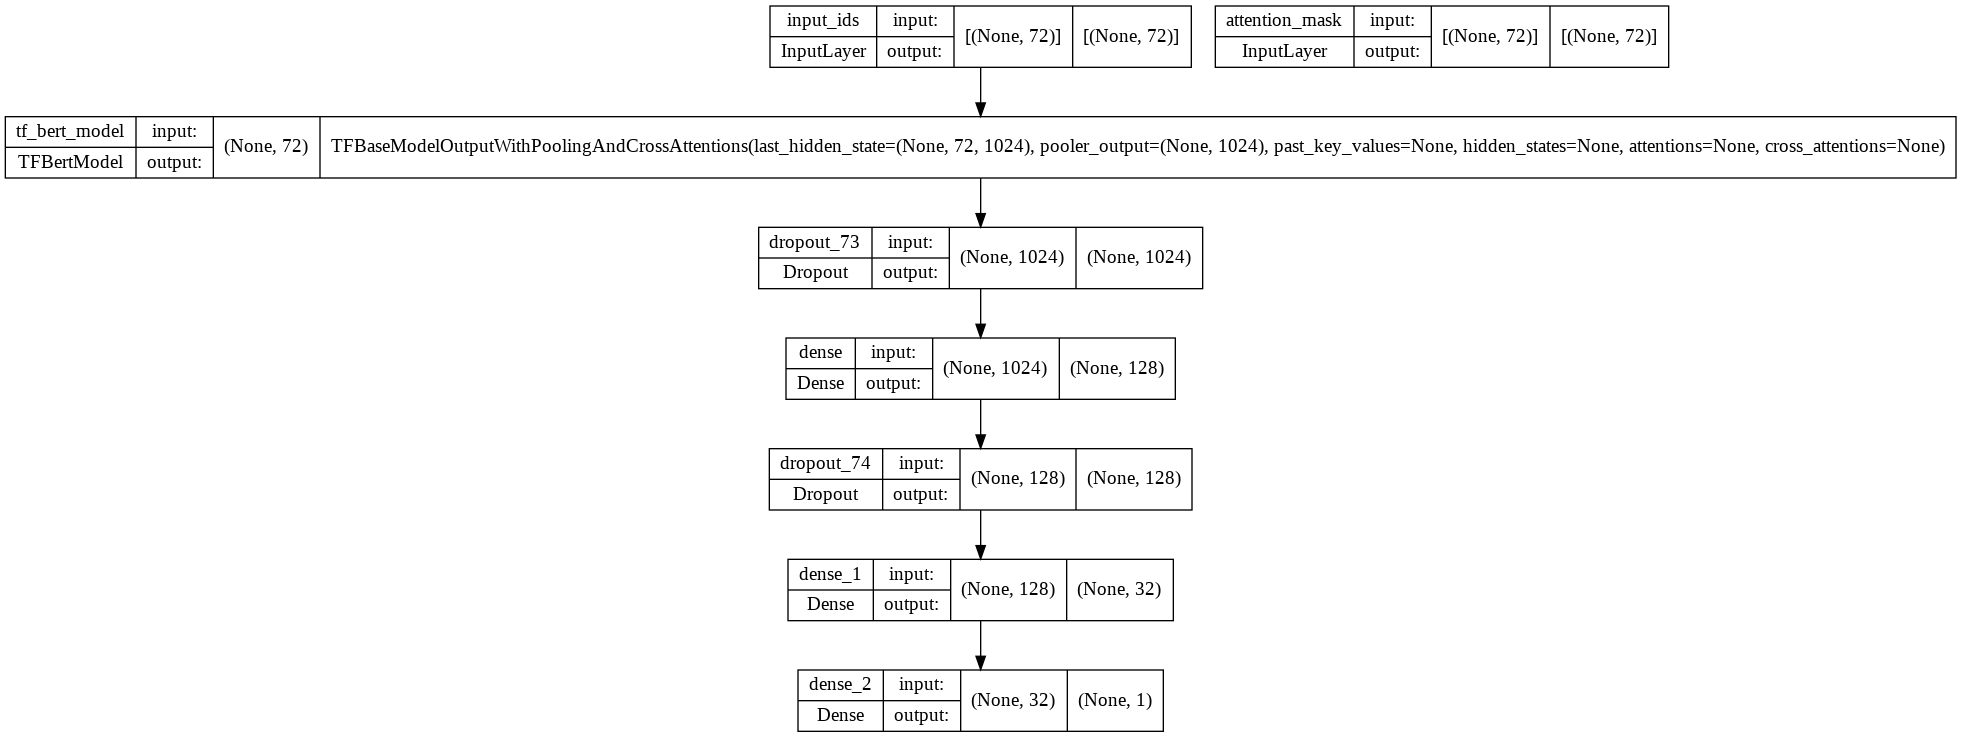

In [ ]:
# Plot Model Visualization.
plot_model(model, show_shapes=True)

In [ ]:
# Weighted Neural Network.
weights_assigned = {0: 1, 1: 6.5}

# Fit the Model.
train_history = model.fit(
    x={
        "input_ids": X_train_encode["input_ids"],
        "attention_mask": X_train_encode["attention_mask"],
    },
    y=y_train,
    class_weight=weights_assigned,
    batch_size=10,
    epochs=10,
)

Epoch 1/10
418/418 [==============================] - 276s 560ms/step - loss: 0.3427 - accuracy: 0.9474
Epoch 2/10
418/418 [==============================] - 234s 559ms/step - loss: 0.1369 - accuracy: 0.9916
Epoch 3/10
418/418 [==============================] - 233s 558ms/step - loss: 0.1194 - accuracy: 0.9933
Epoch 4/10
418/418 [==============================] - 234s 559ms/step - loss: 0.0985 - accuracy: 0.9945
Epoch 5/10
418/418 [==============================] - 233s 558ms/step - loss: 0.0808 - accuracy: 0.9955
Epoch 6/10
418/418 [==============================] - 233s 557ms/step - loss: 0.0870 - accuracy: 0.9959
Epoch 7/10
418/418 [==============================] - 233s 557ms/step - loss: 0.0633 - accuracy: 0.9957
Epoch 8/10
418/418 [==============================] - 233s 557ms/step - loss: 0.0482 - accuracy: 0.9981
Epoch 9/10
418/418 [==============================] - 233s 558ms/step - loss: 0.0452 - accuracy: 0.9976
Epoch 10/10
418/418 [==============================] - 234s 559m

In [ ]:
# Encode Test Dataset.
X_test_encode = tokenizer(
    text=X_test.tolist(),
    add_special_tokens=True,
    max_length=72,
    truncation=True,
    padding=True,
    return_tensors="tf",
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True,
)

In [ ]:
# Predict Test Set.
y_pred = model.predict(
    {
        "input_ids": X_test_encode["input_ids"],
        "attention_mask": X_test_encode["attention_mask"],
    }
)

# Convert Probability Value into Labels.
y_pred = np.where(y_pred > 0.5, 1, 0)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix is: \n", confusion_matrix(y_test, y_pred))
print("\nClassification Report: \n", classification_report(y_test, y_pred))

Confusion Matrix is: 
 [[1205    1]
 [   9  178]]

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      1206
           1       0.99      0.95      0.97       187

    accuracy                           0.99      1393
   macro avg       0.99      0.98      0.98      1393
weighted avg       0.99      0.99      0.99      1393

